# Computer vision for boat self navigating capabilities

## imports

In [201]:
import cv2 as cv
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import os

In [202]:
def show_image(image, title):
    plt.imshow(cv.cvtColor(image, cv.COLOR_BGR2RGB))
    plt.title(title)
    plt.axis('off')
    plt.show()

In [203]:
green = cv.imread('/home/salvador_cb/3_term/engineering_club/data/img/buoy green.png')
red = cv.imread('/home/salvador_cb/3_term/engineering_club/data/img/buoy red.png')
red_green = cv.imread('/home/salvador_cb/3_term/engineering_club/data/img/buoys.png')

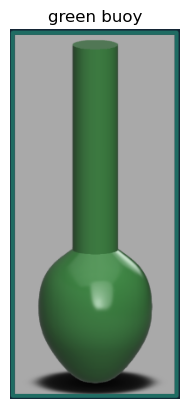

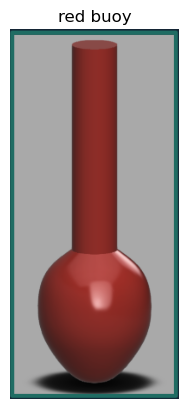

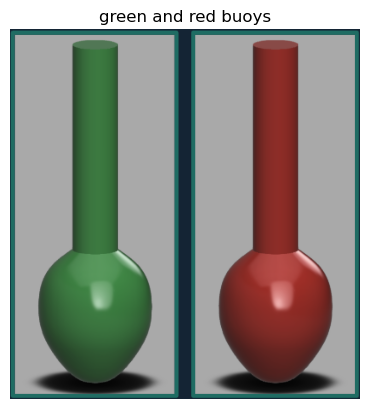

In [204]:
show_image(green, 'green buoy')
show_image(red, 'red buoy')
show_image(red_green, 'green and red buoys')

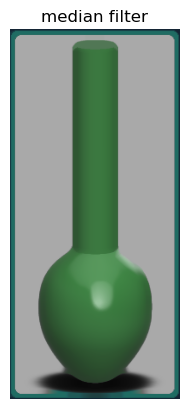

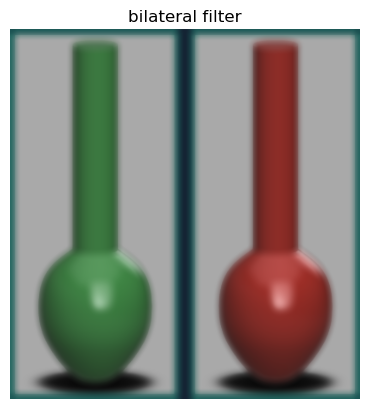

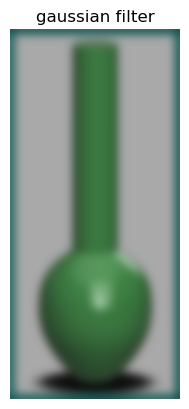

In [205]:
image_median = cv.medianBlur(green, 11)
image_bilateral = cv.bilateralFilter(red_green, 15, 350, 350)
image_gaussian = cv.GaussianBlur(green, (35, 35), 5)
show_image(image_median, 'median filter')
show_image(image_bilateral, 'bilateral filter')
show_image(image_gaussian, 'gaussian filter')

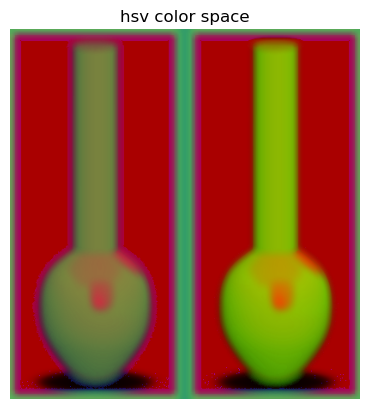

In [206]:
hsv_color = cv.cvtColor(image_bilateral, cv.COLOR_BGR2HSV)
show_image(hsv_color, 'hsv color space')

In [207]:
#green colorspace
lower_g= np.array([40, 50, 0])
upper_g = np.array([80, 255, 255])

#red colorspace
lower_r1 = np.array([0, 80, 0])
upper_r1 = np.array([10, 255, 255])

lower_r2 = np.array([170, 0, 20])
upper_r2 = np.array([180, 255, 255])

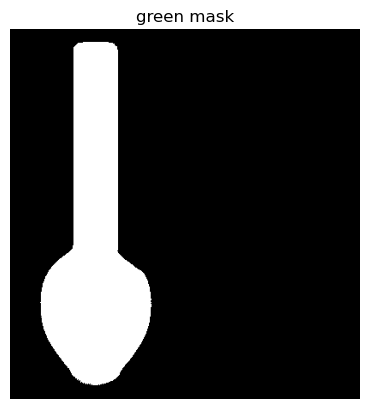

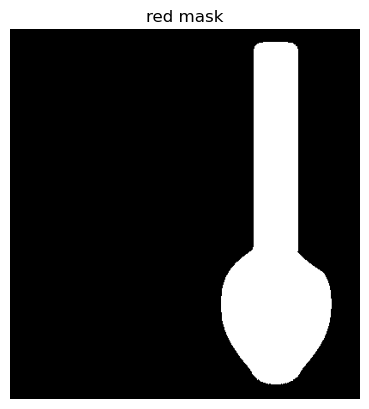

In [208]:
# green mask
mask_g = cv.inRange(hsv_color, lower_g, upper_g)
# red mask
mask_r1 = cv.inRange(hsv_color, lower_r1, upper_r1)
mask_r2 = cv.inRange(hsv_color, lower_r2, upper_r2)
mask_r = mask_r1 | mask_r2

show_image(mask_g, 'green mask')
show_image(mask_r, 'red mask')

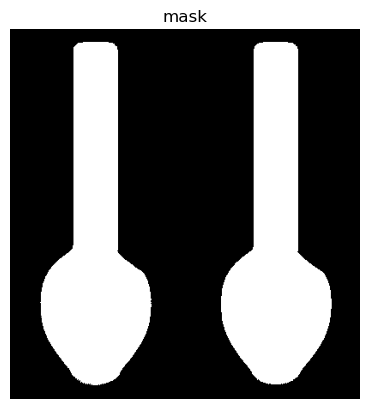

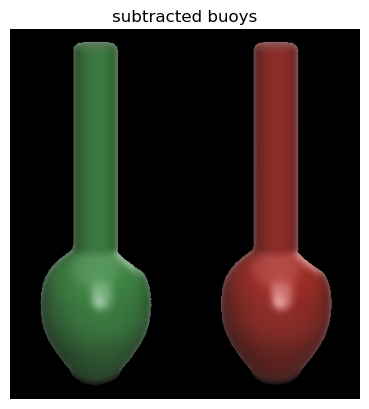

In [209]:

mask = cv.bitwise_or(mask_g, mask_r)
subtracted_buoys = cv.bitwise_and(image_bilateral, image_bilateral, mask=mask)
show_image(mask, 'mask')
show_image(subtracted_buoys, 'subtracted buoys')

In [210]:
def get_contour(mask, image, min_area):
    contours, _ = cv.findContours(mask, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
    for cnt in contours:
        area = cv.contourArea(cnt)
        if area > min_area:
            if mask is mask_g:
                x, y, w, h = cv.boundingRect(cnt)
                cv.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)
                cv.putText(image, 'green_buoy', (x, y - 10), cv.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
            elif mask is mask_r:
                x, y, w, h = cv.boundingRect(cnt)
                cv.rectangle(image, (x, y), (x + w, y + h), (0, 0, 255), 2)
                cv.putText(image, 'red_buoy', (x, y - 10), cv.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 2)
    return None

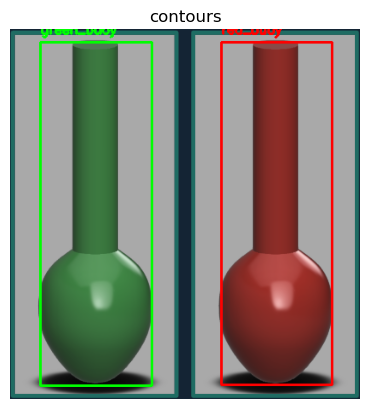

In [211]:
get_contour(mask_g, red_green, 1000)
get_contour(mask_r, red_green, 1000)
show_image(red_green, 'contours')

In [ ]:
class visionNav:
    def __init__(self, image=None):
        self.image = image

    def process_image(self):
        if self.image is not None:
            
            pass
        else:
            print("No image loaded.")